# Plots tarefa A-B

In [ ]:
#!/usr/bin/env python3
"""
Animar pêndulo a partir do arquivo (tempo, omega, theta) e salvar em MP4.

- O vídeo é salvo com o mesmo nome do arquivo de entrada, trocando a extensão para .mp4
- Requer ffmpeg no PATH para salvar MP4. Se não houver, tenta salvar GIF como fallback.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys
import os

# --------------- CONFIGURAÇÃO ---------------
FILE = "tarefa-A/saida-3-12694394.txt"   # arquivo de entrada
L = 1.0                         # comprimento do pêndulo (m)
FPS = 24                        # frames por segundo no vídeo resultante
PLAYBACK_SPEED = 1.0            # 1.0 = tempo real; <1.0 = mais lento (ex: 0.5 dobra duração)
TRAIL_LEN = 150                 # quantos pontos mostrar na trilha
FIGSIZE = (6,6)
DPI_SAVE = 150                  # dpi ao salvar vídeo
# ---------------------------------------------

def load_three_columns(path):
    t_list = []
    w_list = []
    th_list = []
    with open(path, 'r') as f:
        for ln in f:
            s = ln.strip()
            if not s:
                continue
            parts = s.split()
            if len(parts) < 3:
                continue
            # tenta converter, trocando D/d por E/e se necessário
            try:
                t = float(parts[0])
                w = float(parts[1])
                th = float(parts[2])
            except ValueError:
                try:
                    t = float(parts[0].replace('D','E').replace('d','e'))
                    w = float(parts[1].replace('D','E').replace('d','e'))
                    th = float(parts[2].replace('D','E').replace('d','e'))
                except Exception:
                    continue
            t_list.append(t); w_list.append(w); th_list.append(th)
    if len(t_list) == 0:
        raise ValueError("Nenhum dado válido lido do arquivo.")
    # converter para arrays e garantir ordenação por tempo
    t = np.array(t_list)
    idx = np.argsort(t)
    return t[idx], np.array(w_list)[idx], np.array(th_list)[idx]

def main():
    if not os.path.exists(FILE):
        print("Arquivo não encontrado:", FILE)
        sys.exit(1)

    # gera nome do arquivo MP4 automaticamente
    base, _ = os.path.splitext(FILE)
    SAVE_AS = base + ".mp4"

    t, omega, theta = load_three_columns(FILE)
    # unwrapp para evitar salto na interpolação (ângulos em [0,2pi] -> unwrap contínuo)
    theta_unwrapped = np.unwrap(theta)

    t0 = float(t[0]); tf = float(t[-1])
    duration = tf - t0
    if duration <= 0:
        print("Tempo final menor/igual ao inicial. Verifique o arquivo.")
        sys.exit(1)

    # número de frames no vídeo final (ajustado pelo playback_speed)
    n_frames = max(2, int(np.ceil(duration / PLAYBACK_SPEED * FPS)))
    t_uniform = np.linspace(t0, tf, n_frames)

    # interpola theta sobre grade uniforme
    theta_interp = np.interp(t_uniform, t, theta_unwrapped)
    x = L * np.sin(theta_interp)
    y = -L * np.cos(theta_interp)

    # limites com margem
    margin = 0.15 * L
    xmin = x.min() - margin; xmax = x.max() + margin
    ymin = min(y.min(), -L) - margin; ymax = 0.1 * L + margin

    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.set_aspect('equal')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title("Pêndulo — reprodução")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

    linha, = ax.plot([], [], 'o-', lw=2, ms=8)        # haste + massa
    trilha, = ax.plot([], [], ls='None', marker='.', ms=3)  # trilha
    tempo_text = ax.text(0.02, 0.95, "", transform=ax.transAxes, va='top')

    def init():
        linha.set_data([], [])
        trilha.set_data([], [])
        tempo_text.set_text("")
        return linha, trilha, tempo_text

    def animate(i):
        x_mass = x[i]; y_mass = y[i]
        linha.set_data([0.0, x_mass], [0.0, y_mass])
        start = max(0, i - TRAIL_LEN)
        trilha.set_data(x[start:i+1], y[start:i+1])
        # converte t_uniform para tempo "real" mostrado, ajustado pelo playback_speed
        t_shown = t0 + (t_uniform[i] - t0)
        tempo_text.set_text(f"t = {t_shown:.3f} s")
        return linha, trilha, tempo_text

    # intervalo de exibição em ms para o plt.show() ficar com mesma velocidade do vídeo
    interval_ms = 1000.0 / FPS

    ani = animation.FuncAnimation(
        fig, animate, frames=n_frames, init_func=init,
        interval=interval_ms, blit=False, repeat=False
    )

    # ---------- tentativa de salvar MP4 (ffmpeg) ----------
    print(f"Salvando vídeo em {SAVE_AS} (fps={FPS}, duração ≈ {duration/PLAYBACK_SPEED:.2f} s)...")
    try:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=FPS, metadata=dict(artist='animador'), bitrate=2000)
        ani.save(SAVE_AS, writer=writer, dpi=DPI_SAVE)
        print("Vídeo salvo com sucesso em:", SAVE_AS)
    except Exception as e:
        print("Falha ao salvar MP4 com ffmpeg:", e)
        # fallback: tentar GIF com mesmo nome
        try:
            gif_name = base + ".gif"
            print("Tentando salvar GIF como fallback:", gif_name)
            from matplotlib.animation import PillowWriter
            pw = PillowWriter(fps=FPS)
            ani.save(gif_name, writer=pw, dpi=DPI_SAVE)
            print("GIF salvo com sucesso em:", gif_name)
        except Exception as e2:
            print("Falha ao salvar GIF também:", e2)
            print("Instale o ffmpeg (ex: 'sudo apt install ffmpeg' ou use conda/brew) e tente novamente.")

    # mostrar animação na tela
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
"""
Animação das energias (cinética, potencial e total) ao longo do tempo
a partir do arquivo com 4 colunas: tempo, Ec, Ep, Et.

- O vídeo é salvo com o mesmo nome do arquivo de entrada, trocando a extensão para .mp4
- Requer ffmpeg instalado para salvar o MP4.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import sys

# ---------------- CONFIGURAÇÕES ----------------
FILE = "tarefa-A/saida-4-12694394.txt"   # arquivo de entrada
FPS = 24                                 # frames por segundo
PLAYBACK_SPEED = 1.0                     # <1.0 = mais lento
FIGSIZE = (8, 5)
DPI_SAVE = 150
# ------------------------------------------------

def load_four_columns(path):
    """Lê as 4 colunas: tempo, Ec, Ep, Et"""
    t, Ec, Ep, Et = [], [], [], []
    with open(path, 'r') as f:
        for ln in f:
            s = ln.strip()
            if not s:
                continue
            parts = s.split()
            if len(parts) < 4:
                continue
            try:
                vals = [float(p.replace('D','E').replace('d','e')) for p in parts[:4]]
                t.append(vals[0])
                Ec.append(vals[1])
                Ep.append(vals[2])
                Et.append(vals[3])
            except ValueError:
                continue
    return np.array(t), np.array(Ec), np.array(Ep), np.array(Et)

def main():
    if not os.path.exists(FILE):
        print("Arquivo não encontrado:", FILE)
        sys.exit(1)

    # gera nome do vídeo automaticamente
    base, _ = os.path.splitext(FILE)
    SAVE_AS = base + ".mp4"

    t, Ec, Ep, Et = load_four_columns(FILE)
    if len(t) == 0:
        print("Nenhum dado válido encontrado.")
        sys.exit(1)

    # Interpolar para tempo uniforme
    t0, tf = t[0], t[-1]
    n_frames = int(np.ceil((tf - t0) / PLAYBACK_SPEED * FPS))
    t_uniform = np.linspace(t0, tf, n_frames)
    Ec_i = np.interp(t_uniform, t, Ec)
    Ep_i = np.interp(t_uniform, t, Ep)
    Et_i = np.interp(t_uniform, t, Et)

    # Preparar figura
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.set_title("Energias do Pêndulo ao Longo do Tempo")
    ax.set_xlabel("Tempo (s)")
    ax.set_ylabel("Energia (J)")
    ax.grid(True)

    ax.set_xlim(t0, tf)
    ax.set_ylim(min(Ep_i.min(), Ec_i.min(), Et_i.min()) * 1.05,
                max(Ep_i.max(), Ec_i.max(), Et_i.max()) * 1.05)

    line_Ec, = ax.plot([], [], label="Energia Cinética", color='orange', lw=2)
    line_Ep, = ax.plot([], [], label="Energia Potencial", color='royalblue', lw=2)
    line_Et, = ax.plot([], [], label="Energia Total", color='black', lw=2)
    ax.legend(loc='best')
    tempo_text = ax.text(0.02, 0.92, "", transform=ax.transAxes)

    def init():
        line_Ec.set_data([], [])
        line_Ep.set_data([], [])
        line_Et.set_data([], [])
        tempo_text.set_text("")
        return line_Ec, line_Ep, line_Et, tempo_text

    def animate(i):
        line_Ec.set_data(t_uniform[:i], Ec_i[:i])
        line_Ep.set_data(t_uniform[:i], Ep_i[:i])
        line_Et.set_data(t_uniform[:i], Et_i[:i])
        tempo_text.set_text(f"t = {t_uniform[i]:.3f} s")
        return line_Ec, line_Ep, line_Et, tempo_text

    interval_ms = 1000.0 / FPS
    ani = animation.FuncAnimation(fig, animate, frames=n_frames,
                                  init_func=init, interval=interval_ms,
                                  blit=False, repeat=False)

    print(f"Salvando vídeo em {SAVE_AS}...")
    try:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=FPS, bitrate=2000)
        ani.save(SAVE_AS, writer=writer, dpi=DPI_SAVE)
        print("Vídeo salvo com sucesso:", SAVE_AS)
    except Exception as e:
        print("Erro ao salvar MP4:", e)
        print("Tente instalar o ffmpeg.")

    plt.show()

if __name__ == "__main__":
    main()


# Plot tarefa C

Salvando vídeo em tarefa-C/saida-2-12694394.mp4 (fps=24, duração ≈ 120.00 s)...
Vídeo salvo com sucesso em: tarefa-C/saida-2-12694394.mp4


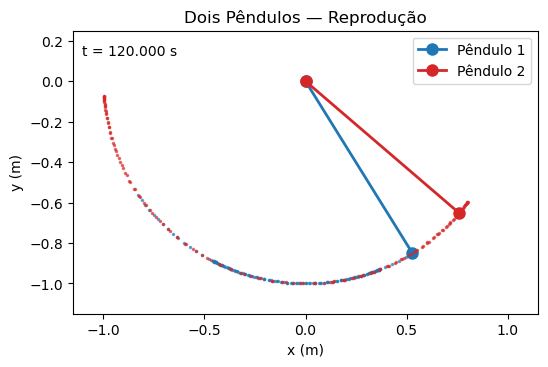

In [1]:
#!/usr/bin/env python3
"""
Animar dois pêndulos a partir do arquivo (tempo, omega1, theta1, omega2, theta2) e salvar em MP4.

- O vídeo é salvo com o mesmo nome do arquivo de entrada, trocando a extensão para .mp4
- Requer ffmpeg no PATH para salvar MP4. Se não houver, tenta salvar GIF como fallback.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys
import os

# --------------- CONFIGURAÇÃO ---------------
FILE = "tarefa-C/saida-2-12694394.txt"   # arquivo de entrada
L = 1.0                         # comprimento do pêndulo (m)
FPS = 24                        # frames por segundo no vídeo resultante
PLAYBACK_SPEED = 1.0            # 1.0 = tempo real; <1.0 = mais lento (ex: 0.5 dobra duração)
TRAIL_LEN = 150                 # quantos pontos mostrar na trilha
FIGSIZE = (6,6)
DPI_SAVE = 150                  # dpi ao salvar vídeo
# ---------------------------------------------

def load_five_columns(path):
    t_list = []
    w1_list, th1_list = [], []
    w2_list, th2_list = [], []
    with open(path, 'r') as f:
        for ln in f:
            s = ln.strip()
            if not s or s.startswith("#") or s.lower().startswith("temp"):
                continue
            parts = s.replace(",", " ").split()
            if len(parts) < 5:
                continue
            try:
                t = float(parts[0])
                w1 = float(parts[1]); th1 = float(parts[2])
                w2 = float(parts[3]); th2 = float(parts[4])
            except ValueError:
                try:
                    t = float(parts[0].replace('D','E').replace('d','e'))
                    w1 = float(parts[1].replace('D','E').replace('d','e'))
                    th1 = float(parts[2].replace('D','E').replace('d','e'))
                    w2 = float(parts[3].replace('D','E').replace('d','e'))
                    th2 = float(parts[4].replace('D','E').replace('d','e'))
                except Exception:
                    continue
            t_list.append(t)
            w1_list.append(w1); th1_list.append(th1)
            w2_list.append(w2); th2_list.append(th2)
    if not t_list:
        raise ValueError("Nenhum dado válido lido do arquivo.")
    t = np.array(t_list)
    idx = np.argsort(t)
    return (t[idx],
            np.array(w1_list)[idx], np.array(th1_list)[idx],
            np.array(w2_list)[idx], np.array(th2_list)[idx])

def main():
    if not os.path.exists(FILE):
        print("Arquivo não encontrado:", FILE)
        sys.exit(1)

    base, _ = os.path.splitext(FILE)
    SAVE_AS = base + ".mp4"

    t, omega1, theta1, omega2, theta2 = load_five_columns(FILE)
    theta1 = np.unwrap(theta1)
    theta2 = np.unwrap(theta2)

    t0, tf = float(t[0]), float(t[-1])
    duration = tf - t0
    if duration <= 0:
        print("Tempo final menor/igual ao inicial. Verifique o arquivo.")
        sys.exit(1)

    n_frames = max(2, int(np.ceil(duration / PLAYBACK_SPEED * FPS)))
    t_uniform = np.linspace(t0, tf, n_frames)

    # Interpolação
    th1 = np.interp(t_uniform, t, theta1)
    th2 = np.interp(t_uniform, t, theta2)
    x1, y1 = L*np.sin(th1), -L*np.cos(th1)
    x2, y2 = L*np.sin(th2), -L*np.cos(th2)

    # Limites com margem
    margin = 0.15 * L
    xmin = min(x1.min(), x2.min()) - margin
    xmax = max(x1.max(), x2.max()) + margin
    ymin = min(y1.min(), y2.min(), -L) - margin
    ymax = 0.1 * L + margin

    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.set_aspect('equal')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title("Dois Pêndulos — Reprodução")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

    # elementos visuais
    linha1, = ax.plot([], [], 'o-', lw=2, ms=8, color='tab:blue', label='Pêndulo 1')
    linha2, = ax.plot([], [], 'o-', lw=2, ms=8, color='tab:red', label='Pêndulo 2')
    trilha1, = ax.plot([], [], ls='None', marker='.', ms=3, color='tab:blue', alpha=0.6)
    trilha2, = ax.plot([], [], ls='None', marker='.', ms=3, color='tab:red', alpha=0.6)
    tempo_text = ax.text(0.02, 0.95, "", transform=ax.transAxes, va='top')
    ax.legend(loc='upper right')

    def init():
        for obj in (linha1, linha2, trilha1, trilha2):
            obj.set_data([], [])
        tempo_text.set_text("")
        return linha1, linha2, trilha1, trilha2, tempo_text

    def animate(i):
        # atualiza posições
        linha1.set_data([0, x1[i]], [0, y1[i]])
        linha2.set_data([0, x2[i]], [0, y2[i]])
        start = max(0, i - TRAIL_LEN)
        trilha1.set_data(x1[start:i+1], y1[start:i+1])
        trilha2.set_data(x2[start:i+1], y2[start:i+1])
        tempo_text.set_text(f"t = {t_uniform[i]:.3f} s")
        return linha1, linha2, trilha1, trilha2, tempo_text

    interval_ms = 1000.0 / FPS
    ani = animation.FuncAnimation(
        fig, animate, frames=n_frames, init_func=init,
        interval=interval_ms, blit=False, repeat=False
    )

    # salvar MP4
    print(f"Salvando vídeo em {SAVE_AS} (fps={FPS}, duração ≈ {duration/PLAYBACK_SPEED:.2f} s)...")
    try:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=FPS, metadata=dict(artist='animador'), bitrate=2000)
        ani.save(SAVE_AS, writer=writer, dpi=DPI_SAVE)
        print("Vídeo salvo com sucesso em:", SAVE_AS)
    except Exception as e:
        print("Falha ao salvar MP4 com ffmpeg:", e)
        try:
            gif_name = base + ".gif"
            print("Tentando salvar GIF como fallback:", gif_name)
            from matplotlib.animation import PillowWriter
            pw = PillowWriter(fps=FPS)
            ani.save(gif_name, writer=pw, dpi=DPI_SAVE)
            print("GIF salvo com sucesso em:", gif_name)
        except Exception as e2:
            print("Falha ao salvar GIF também:", e2)

    plt.show()

if __name__ == "__main__":
    main()


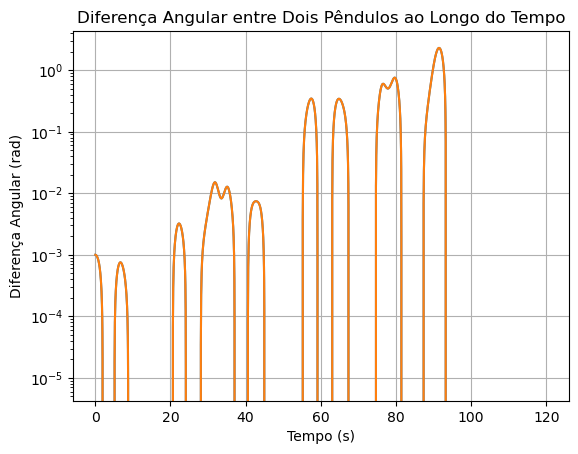

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
file = 'tarefa-C/saida-2-12694394.txt'
df = pd.read_csv(file,sep=',')
time = df['temp'].to_numpy()
dtheta = df['theta2-theta1'].to_numpy()
plt.semilogy(time,dtheta)
plt.plot(time,dtheta)
plt.xlabel('Tempo (s)')
plt.ylabel('Diferença Angular (rad)')
plt.title('Diferença Angular entre Dois Pêndulos ao Longo do Tempo')
plt.grid()
plt.show()

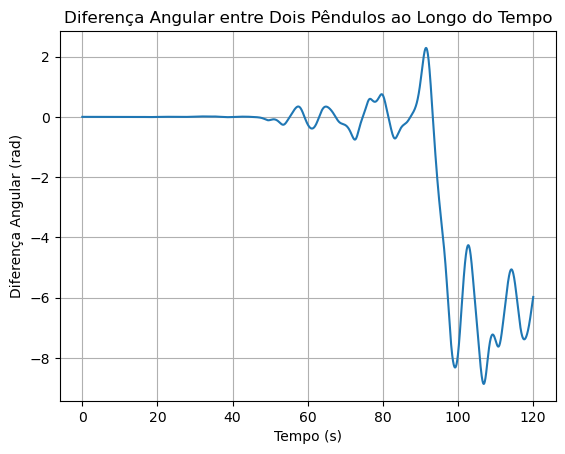

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
file = 'tarefa-C/saida-2-12694394.txt'
df = pd.read_csv(file,sep=',')
time = df['temp'].to_numpy()
dtheta = df['theta2-theta1'].to_numpy()
plt.plot(time,dtheta)
plt.xlabel('Tempo (s)')
plt.ylabel('Diferença Angular (rad)')
plt.title('Diferença Angular entre Dois Pêndulos ao Longo do Tempo')
plt.grid()
plt.show()

# Plot tarefa D

## Faz a animação o pendulo

Anima o movimento do Pendulo

In [ ]:
#!/usr/bin/env python3
"""
Animar pêndulo a partir do arquivo CSV (temp, omega, theta) e salvar em MP4.

- O vídeo é salvo com o mesmo nome do arquivo de entrada, trocando a extensão para .mp4
- Requer ffmpeg no PATH para salvar MP4. Se não houver, tenta salvar GIF como fallback.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys
import os

# --------------- CONFIGURAÇÃO ---------------
FILE = "tarefa-D/saida-1-12694394.txt"   # arquivo de entrada
L = 1.0                         # comprimento do pêndulo (m)
FPS = 24                        # frames por segundo no vídeo resultante
PLAYBACK_SPEED = 1.0            # 1.0 = tempo real
TRAIL_LEN = 150                 # quantos pontos mostrar na trilha
FIGSIZE = (6,6)
DPI_SAVE = 150                  # dpi ao salvar vídeo
# ---------------------------------------------

def load_three_columns(path):
    # usa numpy.loadtxt para ler csv, ignorando cabeçalho
    data = np.loadtxt(path, delimiter=",", skiprows=1)
    if data.shape[1] < 3:
        raise ValueError("Arquivo precisa ter pelo menos 3 colunas (temp, omega, theta)")
    t, w, th = data[:,0], data[:,1], data[:,2]
    return t, w, th

def main():
    if not os.path.exists(FILE):
        print("Arquivo não encontrado:", FILE)
        sys.exit(1)

    base, _ = os.path.splitext(FILE)
    SAVE_AS = base + ".mp4"

    t, omega, theta = load_three_columns(FILE)
    theta_unwrapped = np.unwrap(theta)

    t0, tf = float(t[0]), float(t[-1])
    duration = tf - t0
    if duration <= 0:
        print("Tempo final menor/igual ao inicial. Verifique o arquivo.")
        sys.exit(1)

    n_frames = max(2, int(np.ceil(duration / PLAYBACK_SPEED * FPS)))
    t_uniform = np.linspace(t0, tf, n_frames)

    theta_interp = np.interp(t_uniform, t, theta_unwrapped)
    x = L * np.sin(theta_interp)
    y = -L * np.cos(theta_interp)

    margin = 0.15 * L
    xmin, xmax = x.min() - margin, x.max() + margin
    ymin, ymax = min(y.min(), -L) - margin, 0.1 * L + margin

    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.set_aspect('equal')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title("Pêndulo — reprodução")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

    linha, = ax.plot([], [], 'o-', lw=2, ms=8)
    trilha, = ax.plot([], [], ls='None', marker='.', ms=3)
    tempo_text = ax.text(0.02, 0.95, "", transform=ax.transAxes, va='top')

    def init():
        linha.set_data([], [])
        trilha.set_data([], [])
        tempo_text.set_text("")
        return linha, trilha, tempo_text

    def animate(i):
        x_mass, y_mass = x[i], y[i]
        linha.set_data([0.0, x_mass], [0.0, y_mass])
        start = max(0, i - TRAIL_LEN)
        trilha.set_data(x[start:i+1], y[start:i+1])
        t_shown = t0 + (t_uniform[i] - t0)
        tempo_text.set_text(f"t = {t_shown:.3f} s")
        return linha, trilha, tempo_text

    interval_ms = 1000.0 / FPS

    ani = animation.FuncAnimation(
        fig, animate, frames=n_frames, init_func=init,
        interval=interval_ms, blit=False, repeat=False
    )

    print(f"Salvando vídeo em {SAVE_AS} (fps={FPS}, duração ≈ {duration/PLAYBACK_SPEED:.2f} s)...")
    try:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=FPS, metadata=dict(artist='animador'), bitrate=2000)
        ani.save(SAVE_AS, writer=writer, dpi=DPI_SAVE)
        print("Vídeo salvo com sucesso em:", SAVE_AS)
    except Exception as e:
        print("Falha ao salvar MP4 com ffmpeg:", e)
        try:
            gif_name = base + ".gif"
            print("Tentando salvar GIF como fallback:", gif_name)
            from matplotlib.animation import PillowWriter
            pw = PillowWriter(fps=FPS)
            ani.save(gif_name, writer=pw, dpi=DPI_SAVE)
            print("GIF salvo com sucesso em:", gif_name)
        except Exception as e2:
            print("Falha ao salvar GIF também:", e2)
            print("Instale o ffmpeg (ex: 'sudo apt install ffmpeg') e tente novamente.")

    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
file = 'tarefa-D/saida-2-12694394.txt'
df = pd.read_csv(file,sep=',')


theta = df['theta'].to_numpy()
omega = df['omega'].to_numpy()

plt.scatter(theta, omega)
plt.grid()
plt.show()

## Faz o plot do espaço de fase

In [ ]:
#!/usr/bin/env python3
"""
Animar gráfico de fase (theta, omega) a partir do arquivo CSV.

Compatível com arquivos que têm ou não a coluna 'temp'.
Salva vídeo MP4 (ou GIF como fallback se ffmpeg não estiver disponível).
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os
import sys

# --------------- CONFIGURAÇÕES ---------------
FILE = "tarefa-D/saida-1-12694394.txt"  # arquivo de entrada
FPS = 30                                # frames por segundo
PLAYBACK_SPEED = 1.0                    # 1.0 = tempo real
TRAIL_LEN = 200                         # quantos pontos mostrar na trilha
FIGSIZE = (6, 5)
DPI_SAVE = 150
# ---------------------------------------------

def load_data(path):
    df = pd.read_csv(path, sep=",")
    cols = df.columns.str.strip().tolist()
    
    if "theta" not in cols or "omega" not in cols:
        raise ValueError(f"Arquivo deve conter colunas 'theta' e 'omega'. Colunas encontradas: {cols}")

    theta = df["theta"].to_numpy()
    omega = df["omega"].to_numpy()
    t = df["temp"].to_numpy() if "temp" in cols else None
    return t, theta, omega

def main():
    if not os.path.exists(FILE):
        print("Arquivo não encontrado:", FILE)
        sys.exit(1)

    base, _ = os.path.splitext(FILE)
    SAVE_AS = base + ".mp4"

    t, theta, omega = load_data(FILE)

    if len(theta) != len(omega):
        print("Erro: colunas 'theta' e 'omega' têm comprimentos diferentes!")
        sys.exit(1)

    n_points = len(theta)
    if n_points < 2:
        print("Arquivo muito curto para animar.")
        sys.exit(1)

    # se não houver tempo, gera sequência uniforme
    if t is None:
        t = np.linspace(0, n_points / FPS, n_points)

    # tempo total
    duration = (t[-1] - t[0]) / PLAYBACK_SPEED
    n_frames = n_points

    # Limites do gráfico
    margin_theta = 0.05 * (theta.max() - theta.min())
    margin_omega = 0.05 * (omega.max() - omega.min())
    tmin, tmax = theta.min() - margin_theta, theta.max() + margin_theta
    wmin, wmax = omega.min() - margin_omega, omega.max() + margin_omega

    # Figura
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.set_xlim(tmin, tmax)
    ax.set_ylim(wmin, wmax)
    ax.set_xlabel(r"$\theta$ (rad)")
    ax.set_ylabel(r"$\omega$ (rad/s)")
    ax.set_title("Espaço de Fase — $(\\theta, \\omega)$")
    ax.grid(True)

    # Trajetória completa em cinza
    ax.plot(theta, omega, color="0.8", lw=1, label="Trajetória completa")
    ax.legend(loc="upper right")

    # Elementos animados
    ponto, = ax.plot([], [], 'ro', ms=6)
    trilha, = ax.plot([], [], 'b-', lw=1.2, alpha=0.7)
    tempo_text = ax.text(0.02, 0.95, "", transform=ax.transAxes, va="top")

    def init():
        ponto.set_data([], [])
        trilha.set_data([], [])
        tempo_text.set_text("")
        return ponto, trilha, tempo_text

    def animate(i):
        start = max(0, i - TRAIL_LEN)
        trilha.set_data(theta[start:i+1], omega[start:i+1])
        ponto.set_data([theta[i]], [omega[i]])  # ← CORRIGIDO
        tempo_text.set_text(f"t = {t[i]:.3f} s")
        return ponto, trilha, tempo_text

    interval_ms = 1000.0 / FPS

    ani = animation.FuncAnimation(
        fig, animate, frames=n_frames, init_func=init,
        interval=interval_ms, blit=False, repeat=False
    )

    print(f"Salvando vídeo em {SAVE_AS} (fps={FPS}, duração ≈ {duration:.2f} s)...")
    try:
        Writer = animation.writers["ffmpeg"]
        writer = Writer(fps=FPS, metadata=dict(artist="animador"), bitrate=2000)
        ani.save(SAVE_AS, writer=writer, dpi=DPI_SAVE)
        print("Vídeo salvo com sucesso em:", SAVE_AS)
    except Exception as e:
        print("Falha ao salvar MP4 com ffmpeg:", e)
        try:
            gif_name = base + ".gif"
            print("Tentando salvar GIF como fallback:", gif_name)
            from matplotlib.animation import PillowWriter
            pw = PillowWriter(fps=FPS)
            ani.save(gif_name, writer=pw, dpi=DPI_SAVE)
            print("GIF salvo com sucesso em:", gif_name)
        except Exception as e2:
            print("Falha ao salvar GIF também:", e2)
            print("Instale o ffmpeg (ex: 'sudo apt install ffmpeg') e tente novamente.")

    plt.show()

if __name__ == "__main__":
    main()


## Faz o plot do espaço de fase de Poincaré

In [ ]:
#!/usr/bin/env python3
"""
Animar gráfico de fase (theta, omega) a partir do arquivo CSV.

Compatível com arquivos que têm ou não a coluna 'temp'.
Salva vídeo MP4 (ou GIF como fallback se ffmpeg não estiver disponível).
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os
import sys

# --------------- CONFIGURAÇÕES ---------------
FILE = "tarefa-D/saida-1-12694394.txt"  # arquivo de entrada
FPS = 30                                # frames por segundo
PLAYBACK_SPEED = 1.0                    # 1.0 = tempo real
TRAIL_LEN = 200                         # quantos pontos mostrar na trilha
FIGSIZE = (6, 5)
DPI_SAVE = 150
# ---------------------------------------------

def load_data(path):
    df = pd.read_csv(path, sep=",")
    cols = df.columns.str.strip().tolist()
    
    if "theta" not in cols or "omega" not in cols:
        raise ValueError(f"Arquivo deve conter colunas 'theta' e 'omega'. Colunas encontradas: {cols}")

    theta = df["theta"].to_numpy()
    omega = df["omega"].to_numpy()
    t = df["temp"].to_numpy() if "temp" in cols else None
    return t, theta, omega

def main():
    if not os.path.exists(FILE):
        print("Arquivo não encontrado:", FILE)
        sys.exit(1)

    base, _ = os.path.splitext(FILE)
    SAVE_AS = base + ".mp4"

    t, theta, omega = load_data(FILE)

    if len(theta) != len(omega):
        print("Erro: colunas 'theta' e 'omega' têm comprimentos diferentes!")
        sys.exit(1)

    n_points = len(theta)
    if n_points < 2:
        print("Arquivo muito curto para animar.")
        sys.exit(1)

    # se não houver tempo, gera sequência uniforme
    if t is None:
        t = np.linspace(0, n_points / FPS, n_points)

    # tempo total
    duration = (t[-1] - t[0]) / PLAYBACK_SPEED
    n_frames = n_points

    # Limites do gráfico
    margin_theta = 0.05 * (theta.max() - theta.min())
    margin_omega = 0.05 * (omega.max() - omega.min())
    tmin, tmax = theta.min() - margin_theta, theta.max() + margin_theta
    wmin, wmax = omega.min() - margin_omega, omega.max() + margin_omega

    # Figura
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.set_xlim(tmin, tmax)
    ax.set_ylim(wmin, wmax)
    ax.set_xlabel(r"$\theta$ (rad)")
    ax.set_ylabel(r"$\omega$ (rad/s)")
    ax.set_title("Espaço de Fase — $(\\theta, \\omega)$")
    ax.grid(True)

    # Trajetória completa em cinza
    ax.plot(theta, omega, color="0.8", lw=1, label="Trajetória completa")
    ax.legend(loc="upper right")

    # Elementos animados
    ponto, = ax.plot([], [], 'ro', ms=6)
    trilha, = ax.plot([], [], 'b-', lw=1.2, alpha=0.7)
    tempo_text = ax.text(0.02, 0.95, "", transform=ax.transAxes, va="top")

    def init():
        ponto.set_data([], [])
        trilha.set_data([], [])
        tempo_text.set_text("")
        return ponto, trilha, tempo_text

    def animate(i):
        start = max(0, i - TRAIL_LEN)
        trilha.set_data(theta[start:i+1], omega[start:i+1])
        ponto.set_data([theta[i]], [omega[i]])  # ← CORRIGIDO
        tempo_text.set_text(f"t = {t[i]:.3f} s")
        return ponto, trilha, tempo_text

    interval_ms = 1000.0 / FPS

    ani = animation.FuncAnimation(
        fig, animate, frames=n_frames, init_func=init,
        interval=interval_ms, blit=False, repeat=False
    )

    print(f"Salvando vídeo em {SAVE_AS} (fps={FPS}, duração ≈ {duration:.2f} s)...")
    try:
        Writer = animation.writers["ffmpeg"]
        writer = Writer(fps=FPS, metadata=dict(artist="animador"), bitrate=2000)
        ani.save(SAVE_AS, writer=writer, dpi=DPI_SAVE)
        print("Vídeo salvo com sucesso em:", SAVE_AS)
    except Exception as e:
        print("Falha ao salvar MP4 com ffmpeg:", e)
        try:
            gif_name = base + ".gif"
            print("Tentando salvar GIF como fallback:", gif_name)
            from matplotlib.animation import PillowWriter
            pw = PillowWriter(fps=FPS)
            ani.save(gif_name, writer=pw, dpi=DPI_SAVE)
            print("GIF salvo com sucesso em:", gif_name)
        except Exception as e2:
            print("Falha ao salvar GIF também:", e2)
            print("Instale o ffmpeg (ex: 'sudo apt install ffmpeg') e tente novamente.")

    plt.show()

if __name__ == "__main__":
    main()
